In [1]:
import pandas as pd
rway_img_df_ok = pd.read_csv("collection_images_download.csv")

In [2]:
rway_img_df = rway_img_df_ok.copy()

# EXTRACT BRAND FROM IMAGE NAME
# Creazione delle nuove colonne
rway_img_df['brand'] = rway_img_df['image_name'].str.lower()
rway_img_df['brand'] = rway_img_df['brand'].str.split('couture').str[0]
rway_img_df['brand'] = rway_img_df['brand'].str.split('ready-to-wear').str[0]
rway_img_df['brand'] = rway_img_df['brand'].str.split('menswear').str[0]
rway_img_df['brand'] = rway_img_df['brand'].str.replace("-", " ")
rway_img_df['brand'] = rway_img_df['brand'].str.strip()

In [3]:
# create a small dataframe with the brand in scope
brand_in_scope = ['chanel', 'rick owens', 'givenchy']
rway_img_df_small = pd.DataFrame()

for i,row in enumerate(rway_img_df['brand']):
    if row in brand_in_scope:
        rway_img_df_small = rway_img_df_small.append(rway_img_df.iloc[i])
        
rway_img_df_small['image_path_no_bkgnd'] = rway_img_df_small['image_path'].astype(str)

# Execute 
# for each row in rway_img_df_small['image_path_no_bkgnd'] change the output path
for index, row in rway_img_df_small.iterrows():
    # Split the image path into base name and extension
    base_name, extension = row['image_path_no_bkgnd'].split('.')

    # Add "-no-bkgnd" to the base name
    new_base_name = f"{base_name}-no-bkgnd"

    # Concatenate the new base name with the extension
    new_image_path = f"{new_base_name}.{extension}"

    # Replace the original image path with the new image path
    rway_img_df_small.at[index, 'image_path_no_bkgnd'] = new_image_path


/var/folders/3c/t3n4ptk97wl0rt09z81znxsw0000gn/T/ipykernel_6779/2671282471.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rway_img_df_small = rway_img_df_small.append(rway_img_df.iloc[i])
/var/folders/3c/t3n4ptk97wl0rt09z81znxsw0000gn/T/ipykernel_6779/2671282471.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rway_img_df_small = rway_img_df_small.append(rway_img_df.iloc[i])
/var/folders/3c/t3n4ptk97wl0rt09z81znxsw0000gn/T/ipykernel_6779/2671282471.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rway_img_df_small = rway_img_df_small.append(rway_img_df.iloc[i])
/var/folders/3c/t3n4ptk97wl0rt09z81znxsw0000gn/T/ipykernel_6779/2671282471.py:7: FutureWarning: The frame.append method is deprecated and will be removed 

In [32]:

#! it's takes 105m for 1694 imgs (% of full sample size)
#! Time estimate per img 2secs

from rembg import remove
import os

path_prefix = "./imgs/images/images/"

# Assuming rway_img_df_small is a pandas DataFrame containing the image paths
# with a column named 'image_path_no_bkgnd'

for index, row in rway_img_df_small.iterrows():
    input_path = f"{path_prefix}{row['image_path']}"
    output_path = f"{path_prefix}{row['image_path_no_bkgnd']}"

    with open(input_path, 'rb') as i:
        with open(output_path, 'wb') as o:
            input_data = i.read()
            output_data = remove(input_data)
            o.write(output_data)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
"""import cv2
import numpy as np

output_image = cv2.imread(output_path)

# Resize the image to 260x260 pixels
resized_image = cv2.resize(output_image, (260, 260))

# Display the final resized image with a white background
cv2.imshow('Resized Image with White Background', resized_image)
cv2.waitKey(0)
cv2.destroyAllWindows()"""


"import cv2\nimport numpy as np\n\noutput_image = cv2.imread(output_path)\n\n# Resize the image to 260x260 pixels\nresized_image = cv2.resize(output_image, (260, 260))\n\n# Display the final resized image with a white background\ncv2.imshow('Resized Image with White Background', resized_image)\ncv2.waitKey(0)\ncv2.destroyAllWindows()"

# Preprocessing

## test semplice

In [8]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model

# My custom simple_vgg16 
def simple_vgg16(input_shape=(224, 224, 3), num_classes=10):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    return model

# Load the image data and labels

# Split the data into training and validation sets
X_train_paths, X_val_paths, y_train, y_val = train_test_split(
    rway_img_df_small['image_path_no_bkgnd'],
    rway_img_df_small['brand'],
    test_size=0.2,
    random_state=1234
)

# Define image dimensions (img_height and img_width) to resize the images during preprocessing.
img_height, img_width = 224, 224

# Map the brand labels in y_train and y_val to their corresponding integer labels using the brand_to_label dictionary.
brand_to_label = {brand: i for i, brand in enumerate(np.unique(rway_img_df_small['brand']))}

# Map brand labels to integer labels
y_train = np.array([brand_to_label[brand] for brand in y_train])
y_val = np.array([brand_to_label[brand] for brand in y_val])

# Calculate the number of classes (num_classes) based on the unique labels.
num_classes = len(brand_to_label)

# Define the preprocess_image function to load, resize, and normalize the pixel values of the images.
def preprocess_image(image_path):
    image_path = './imgs/images/images/' + image_path  # Add the path prefix
    image = load_img(image_path, target_size=(img_height, img_width))
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image

# Preprocess the images in X_train and X_val by applying the preprocess_image function to each image path.
X_train = np.array([preprocess_image(path) for path in X_train_paths])
X_val = np.array([preprocess_image(path) for path in X_val_paths])

# Convert the integer labels in y_train and y_val to one-hot encoded vectors using tf.keras.utils.to_categorical.
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

# Create the custom simple_vgg16 model
input_shape = (img_height, img_width, 3)
model = simple_vgg16(input_shape=input_shape, num_classes=num_classes)

# Compile the model with an appropriate optimizer and loss function (e.g., 'adam' optimizer and 'categorical_crossentropy' loss)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the preprocessed data
history_100_new = model.fit(X_train, y_train, batch_size=32, epochs=500, validation_data=(X_val, y_val))


Epoch 1/500


2023-08-04 06:13:58.539203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 1.7233 - accuracy: 0.4106

2023-08-04 06:14:32.424769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 37s 574ms/step - loss: 1.7233 - accuracy: 0.4106 - val_loss: 1.0177 - val_accuracy: 0.5797
Epoch 2/500
63/63 [==============================] - 36s 565ms/step - loss: 0.8962 - accuracy: 0.5889 - val_loss: 0.7785 - val_accuracy: 0.6295
Epoch 3/500
63/63 [==============================] - 36s 567ms/step - loss: 0.6180 - accuracy: 0.7424 - val_loss: 0.7283 - val_accuracy: 0.6813
Epoch 4/500
63/63 [==============================] - 36s 565ms/step - loss: 0.4284 - accuracy: 0.8406 - val_loss: 1.0871 - val_accuracy: 0.6275
Epoch 5/500
63/63 [==============================] - 63s 1s/step - loss: 0.2809 - accuracy: 0.8939 - val_loss: 0.8318 - val_accuracy: 0.7012
Epoch 6/500
63/63 [==============================] - 35s 562ms/step - loss: 0.1908 - accuracy: 0.9357 - val_loss: 0.8678 - val_accuracy: 0.7131
Epoch 7/500
63/63 [==============================] - 35s 561ms/step - loss: 0.1150 - accuracy: 0.9626 - val_loss: 0.9996 - val_accuracy: 0.7271
Epoch 8

In [9]:
import json 
json.dump(history_100_new.history, open('history_100_new.json', 'w'))

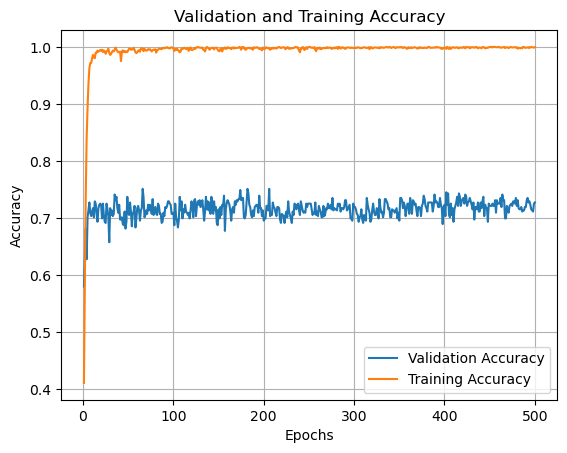

In [10]:
import matplotlib.pyplot as plt

# Supponiamo che tu abbia già addestrato il modello utilizzando model.fit()

# Ottieni i risultati dell'addestramento dallo storico del modello

# Recupera i valori di val_accuracy e accuracy per ogni epoca
val_accuracy = history_100_new.history['val_accuracy']
accuracy = history_100_new.history['accuracy']
epochs = range(1, len(val_accuracy) + 1)

# Plotta i risultati
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()


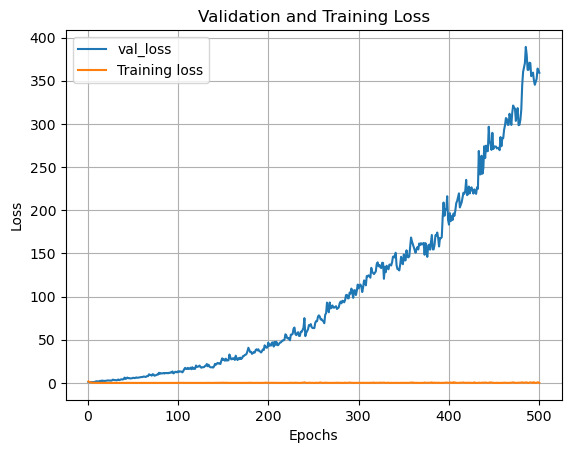

In [ ]:
import matplotlib.pyplot as plt

# Supponiamo che tu abbia già addestrato il modello utilizzando model.fit()

# Ottieni i risultati dell'addestramento dallo storico del modello

# Recupera i valori di val_accuracy e accuracy per ogni epoca
val_accuracy = history_100_new.history['val_loss']
accuracy = history_100_new.history['loss']
epochs = range(1, len(val_accuracy) + 1)

# Plotta i risultati
plt.plot(epochs, val_accuracy, label='val_loss')
plt.plot(epochs, accuracy, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation and Training Loss')
plt.legend()
plt.grid(True)
plt.show()


## test semplice

In [20]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers.legacy import Adam

# Define the custom AttentionBlock
class AttentionBlock(tf.keras.layers.Layer):
    def __init__(self, in_features_l, in_features_g, attn_features, up_factor, normalize_attn=True):
        super(AttentionBlock, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        self.W_l = tf.keras.layers.Conv2D(filters=attn_features, kernel_size=1, padding='same', activation='relu')
        self.W_g = tf.keras.layers.Conv2D(filters=attn_features, kernel_size=1, padding='same', activation='relu')
        self.phi = tf.keras.layers.Conv2D(filters=1, kernel_size=1, padding='same')

    def call(self, l, g):
        N, H, W, C = l.shape
        l_ = self.W_l(l)
        g_ = self.W_g(g)
        if self.up_factor > 1:
            g_ = tf.image.resize(g_, size=(H, W), method='bilinear')
        c = self.phi(tf.nn.relu(l_ + g_))  # batch_size x 1 x W x H

        # compute attn map
        if self.normalize_attn:
            a = tf.nn.softmax(tf.reshape(c, (N, 1, -1)), axis=2)
            a = tf.reshape(a, (N, 1, H, W))
        else:
            a = tf.sigmoid(c)
        # re-weight the local feature
        f = tf.multiply(a, l)  # batch_size x C x W x H
        if self.normalize_attn:
            output = tf.reduce_sum(f, axis=[2, 3])  # weighted sum
        else:
            output = tf.reduce_mean(f, axis=[2, 3])  # global average pooling
        return a, output

# Define the custom AttnVGG model
class AttnVGG(Model):
    def __init__(self, num_classes, normalize_attn=False, dropout=None):
        super(AttnVGG, self).__init__()
        self.vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        self.conv_block1 = tf.keras.Sequential(self.vgg16.layers[:6])
        self.conv_block2 = tf.keras.Sequential(self.vgg16.layers[7:13])
        self.conv_block3 = tf.keras.Sequential(self.vgg16.layers[14:20])
        self.conv_block4 = tf.keras.Sequential(self.vgg16.layers[21:27])
        self.conv_block5 = tf.keras.Sequential(self.vgg16.layers[28:34])
        self.pool = tf.keras.layers.MaxPool2D(pool_size=(7, 7), strides=1)
        self.dpt = None
        if dropout is not None:
            self.dpt = Dropout(dropout)
        self.cls = Dense(units=num_classes)

        # initialize the attention blocks defined above
        self.attn1 = AttentionBlock(256, 512, 256, 4, normalize_attn=normalize_attn)
        self.attn2 = AttentionBlock(512, 512, 256, 2, normalize_attn=normalize_attn)

    def call(self, x):
        block1 = self.conv_block1(x)       # /1
        block2 = self.conv_block2(block1)  # /2
        block3 = self.conv_block3(block2)  # /4
        block4 = self.conv_block4(block3)  # /8
        block5 = self.conv_block5(block4)  # /16
        N, H, W, C = block5.shape

        g = self.pool(block5)
        g = Flatten()(g)
        a1, g1 = self.attn1(block3, block5)
        a2, g2 = self.attn2(block4, block5)
        g_hat = tf.concat((g, g1, g2), axis=1)  # batch_size x C
        if self.dpt is not None:
            g_hat = self.dpt(g_hat)
        out = self.cls(g_hat)

        return [out, a1, a2]

# Load the image data and labels
# ... (your code to load the data and preprocess it)
# Split the data into training and validation sets
X_train_paths, X_val_paths, y_train, y_val = train_test_split(
    rway_img_df_small['image_path'],
    rway_img_df_small['brand'],
    test_size=0.2,
    random_state=1234
)

# Define image dimensions (img_height and img_width) to resize the images during preprocessing.
img_height, img_width = 224, 224

# Map the brand labels in y_train and y_val to their corresponding integer labels using the brand_to_label dictionary.
brand_to_label = {brand: i for i, brand in enumerate(np.unique(rway_img_df_small['brand']))}

# Map brand labels to integer labels
y_train = np.array([brand_to_label[brand] for brand in y_train])
y_val = np.array([brand_to_label[brand] for brand in y_val])

# Calculate the number of classes (num_classes) based on the unique labels.
num_classes = len(brand_to_label)

# Define the preprocess_image function to load, resize, and normalize the pixel values of the images.
def preprocess_image(image_path):
    image_path = './imgs/images/images/' + image_path  # Add the path prefix
    image = load_img(image_path, target_size=(img_height, img_width))
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image

# Preprocess the images in X_train and X_val by applying the preprocess_image function to each image path.
X_train = np.array([preprocess_image(path) for path in X_train_paths])
X_val = np.array([preprocess_image(path) for path in X_val_paths])

# Convert the integer labels in y_train and y_val to one-hot encoded vectors using tf.keras.utils.to_categorical.
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)


# Create the AttnVGG model
num_classes = len(brand_to_label)  # Number of classes
normalize_attn = False  # Set to True if you want to normalize attention weights
dropout = 0.5  # Set to None if you don't want dropout, otherwise set to a dropout rate

# Input layer
input_shape = (img_height, img_width, 3)
inputs = Input(shape=input_shape)

# Create the AttnVGG model
model = AttnVGG(num_classes=num_classes, normalize_attn=normalize_attn, dropout=dropout)(inputs)

# Define the model with the input and output
model = Model(inputs=inputs, outputs=model[0])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the preprocessed data
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val))


Epoch 1/100


2023-08-08 11:55:51.359102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/63 [=================>............] - ETA: 3:04 - loss: 5.3136 - accuracy: 0.3301

KeyboardInterrupt: 

--------------------------------

## snotherr one

In [11]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# Define the custom AttentionBlock
class AttentionBlock(tf.keras.layers.Layer):
    def __init__(self, in_features_l, in_features_g, attn_features, up_factor, normalize_attn=True):
        super(AttentionBlock, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        self.W_l = tf.keras.layers.Conv2D(filters=attn_features, kernel_size=1, activation='relu')
        self.W_g = tf.keras.layers.Conv2D(filters=attn_features, kernel_size=1, activation='relu')
        self.phi = tf.keras.layers.Conv2D(filters=1, kernel_size=1)

    def call(self, l, g):
        l_ = self.W_l(l)
        g_ = self.W_g(g)
        if self.up_factor > 1:
            g_ = tf.image.resize(g_, size=l.shape[1:3], method='bilinear')
        c = self.phi(tf.nn.relu(l_ + g_))

        # compute attn map
        if self.normalize_attn:
            a = tf.nn.softmax(c, axis=[1, 2])
        else:
            a = tf.sigmoid(c)
        # re-weight the local feature
        f = tf.multiply(a, l)
        if self.normalize_attn:
            output = tf.reduce_sum(f, axis=[1, 2])
        else:
            output = tf.reduce_mean(f, axis=[1, 2])
        return a, output

# Define the custom AttnVGG model
class AttnVGG(Model):
    def __init__(self, num_classes, normalize_attn=False, dropout=None):
        super(AttnVGG, self).__init__()
        self.vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        self.conv_blocks = [tf.keras.Sequential(self.vgg16.layers[start:end]) for start, end in [(0, 6), (7, 13), (14, 20), (21, 27), (28, 34)]]
        self.pool = tf.keras.layers.AvgPool2D(pool_size=(7, 7), strides=1)
        self.dpt = None
        if dropout is not None:
            self.dpt = Dropout(dropout)
        self.cls = Dense(units=num_classes)

        # initialize the attention blocks defined above
        self.attn1 = AttentionBlock(256, 512, 256, 4, normalize_attn=normalize_attn)
        self.attn2 = AttentionBlock(512, 512, 256, 2, normalize_attn=normalize_attn)

    def call(self, x):
        blocks = [conv_block(x) for conv_block in self.conv_blocks]
        g = self.pool(blocks[-1])
        g = GlobalAveragePooling2D()(g)
        a1, g1 = self.attn1.call(blocks[2], blocks[-1])
        a2, g2 = self.attn2.call(blocks[3], blocks[-1])
        g_hat = tf.concat((g, g1, g2), axis=1)
        if self.dpt is not None:
            g_hat = self.dpt(g_hat)
        out = self.cls(g_hat)

        return [out, a1, a2]

In [13]:
# Load the image data and labels
# ... (your code to load the data and preprocess it)
X_train_paths, X_val_paths, y_train, y_val = train_test_split(
    rway_img_df_small['image_path_no_bkgnd'],
    rway_img_df_small['brand'],
    test_size=0.2,
    random_state=1234
)

# Define image dimensions (img_height and img_width) to resize the images during preprocessing.
img_height, img_width = 224, 224

# Map the brand labels in y_train and y_val to their corresponding integer labels using the brand_to_label dictionary.
brand_to_label = {brand: i for i, brand in enumerate(np.unique(rway_img_df_small['brand']))}

# Map brand labels to integer labels
y_train = np.array([brand_to_label[brand] for brand in y_train])
y_val = np.array([brand_to_label[brand] for brand in y_val])


# ... (your code to split data, map labels, and preprocess images)
# Calculate the number of classes (num_classes) based on the unique labels.
num_classes = len(brand_to_label)

# Define the preprocess_image function to load, resize, and normalize the pixel values of the images.
def preprocess_image(image_path):
    image_path = './imgs/images/images/' + image_path  # Add the path prefix
    image = load_img(image_path, target_size=(img_height, img_width))
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image

# Preprocess the images in X_train and X_val by applying the preprocess_image function to each image path.
X_train = np.array([preprocess_image(path) for path in X_train_paths])
X_val = np.array([preprocess_image(path) for path in X_val_paths])

# Convert the integer labels in y_train and y_val to one-hot encoded vectors using tf.keras.utils.to_categorical.
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

In [14]:

# Create the AttnVGG model
num_classes = len(brand_to_label)  # Number of classes
normalize_attn = False  # Set to True if you want to normalize attention weights
dropout = 0.5  # Set to None if you don't want dropout, otherwise set to a dropout rate

# Input layer
input_shape = (img_height, img_width, 3)
inputs = Input(shape=input_shape)


# Instantiate the AttnVGG model
attn_vgg_model = AttnVGG(num_classes=num_classes, normalize_attn=normalize_attn, dropout=dropout)

# Input layer
input_shape = (img_height, img_width, 3)
inputs = Input(shape=input_shape)

# Create the model with the input and output
outputs = attn_vgg_model(inputs)[0]
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model using the preprocessed data
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))


ValueError: Exception encountered when calling layer "attn_vgg_2" (type AttnVGG).

in user code:

    File "/var/folders/3c/t3n4ptk97wl0rt09z81znxsw0000gn/T/ipykernel_6779/2279624271.py", line 57, in call  *
        blocks = [conv_block(x) for conv_block in self.conv_blocks]
    File "/Users/elenaabcc/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/Users/elenaabcc/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_11' (type Sequential).
    
    Input 0 of layer "block3_conv1" is incompatible with the layer: expected axis -1 of input shape to have value 128, but received input with shape (None, 224, 224, 3)
    
    Call arguments received by layer 'sequential_11' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
      • training=None
      • mask=None


Call arguments received by layer "attn_vgg_2" (type AttnVGG):
  • x=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)

## Prep photo

In [4]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model

# Load the image data and labels

# Split the data into training and validation sets
X_train_paths, X_val_paths, y_train, y_val = train_test_split(
    rway_img_df_small['image_path_no_bkgnd'],
    rway_img_df_small['brand'],
    test_size=0.2,
    random_state=1234
)

# Define image dimensions (img_height and img_width) to resize the images during preprocessing.
img_height, img_width = 224, 224

# Map the brand labels in y_train and y_val to their corresponding integer labels using the brand_to_label dictionary.
brand_to_label = {brand: i for i, brand in enumerate(np.unique(rway_img_df_small['brand']))}

# Map brand labels to integer labels
y_train = np.array([brand_to_label[brand] for brand in y_train])
y_val = np.array([brand_to_label[brand] for brand in y_val])

# Calculate the number of classes (num_classes) based on the unique labels.
num_classes = len(brand_to_label)

# Define the preprocess_image function to load, resize, and normalize the pixel values of the images.
def preprocess_image(image_path):
    image_path = './imgs/images/images/' + image_path  # Add the path prefix
    image = load_img(image_path, target_size=(img_height, img_width))
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image

# Preprocess the images in X_train and X_val by applying the preprocess_image function to each image path.
X_train = np.array([preprocess_image(path) for path in X_train_paths])
X_val = np.array([preprocess_image(path) for path in X_val_paths])

# Convert the integer labels in y_train and y_val to one-hot encoded vectors using tf.keras.utils.to_categorical.
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)


# VGG16 con 100 epoche


In [18]:
# Convert labels to one-hot encoded vectors
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

# Load the VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

# Add attention mechanism
attention = Dense(1, activation='tanh')(base_model.output)
attention = GlobalAveragePooling2D()(attention)
attention = Multiply()([base_model.output, attention])

# Add the top classification layer by applying a dense layer with a tanh activation function, followed by global average pooling and element-wise multiplication.
output = GlobalAveragePooling2D()(attention)
# Use global average pooling and a dense layer with softmax activation for multi-class classification.
output = Dense(num_classes, activation='softmax')(output)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_100 = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

# Save the trained model
model.save('./image_classification_model_100.h5') 


Epoch 1/100


2023-07-21 23:28:06.435183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - ETA: 0s - loss: 3.7482 - accuracy: 0.4871

2023-07-21 23:29:49.765625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 109s 3s/step - loss: 3.7482 - accuracy: 0.4871 - val_loss: 0.6943 - val_accuracy: 0.5192
Epoch 2/100
43/43 [==============================] - 111s 3s/step - loss: 0.6943 - accuracy: 0.4900 - val_loss: 0.7141 - val_accuracy: 0.5192
Epoch 3/100
43/43 [==============================] - 117s 3s/step - loss: 0.6953 - accuracy: 0.5269 - val_loss: 0.6990 - val_accuracy: 0.4808
Epoch 4/100
43/43 [==============================] - 120s 3s/step - loss: 0.6951 - accuracy: 0.4893 - val_loss: 0.7102 - val_accuracy: 0.5192
Epoch 5/100
43/43 [==============================] - 132s 3s/step - loss: 0.6933 - accuracy: 0.4871 - val_loss: 0.6931 - val_accuracy: 0.5192
Epoch 6/100
43/43 [==============================] - 133s 3s/step - loss: 0.6932 - accuracy: 0.4974 - val_loss: 0.6933 - val_accuracy: 0.4808
Epoch 7/100
43/43 [==============================] - 138s 3s/step - loss: 0.6931 - accuracy: 0.4841 - val_loss: 0.6944 - val_accuracy: 0.4808
Epoch 8/100
43/43 

/Users/elenaabcc/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
import json 
json.dump(history_100.history, open('history_100.json', 'w'))

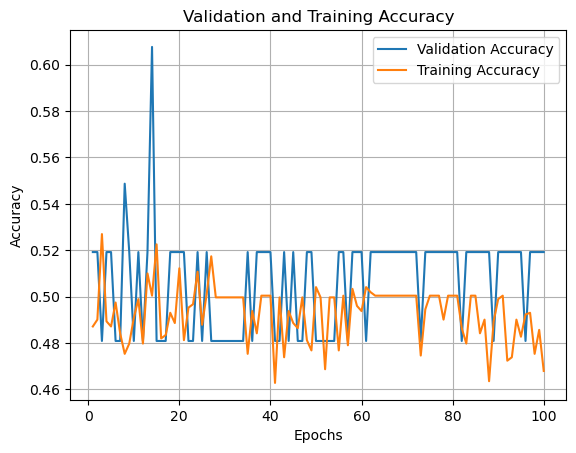

In [22]:
import matplotlib.pyplot as plt

# Supponiamo che tu abbia già addestrato il modello utilizzando model.fit()

# Ottieni i risultati dell'addestramento dallo storico del modello

# Recupera i valori di val_accuracy e accuracy per ogni epoca
val_accuracy = history_100.history['val_accuracy']
accuracy = history_100.history['accuracy']
epochs = range(1, len(val_accuracy) + 1)

# Plotta i risultati
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()


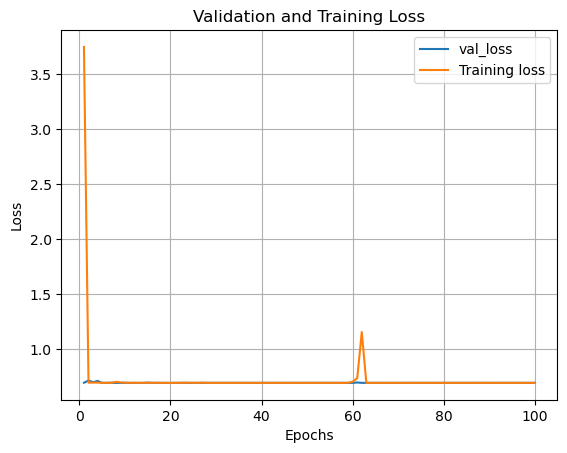

In [23]:
import matplotlib.pyplot as plt

# Supponiamo che tu abbia già addestrato il modello utilizzando model.fit()

# Ottieni i risultati dell'addestramento dallo storico del modello

# Recupera i valori di val_accuracy e accuracy per ogni epoca
val_accuracy = history_100.history['val_loss']
accuracy = history_100.history['loss']
epochs = range(1, len(val_accuracy) + 1)

# Plotta i risultati
plt.plot(epochs, val_accuracy, label='val_loss')
plt.plot(epochs, accuracy, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation and Training Loss')
plt.legend()
plt.grid(True)
plt.show()


# VGG16 con 10 epoche

In [5]:
# Convert labels to one-hot encoded vectors
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

# Load the VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

# Add attention mechanism
attention = Dense(1, activation='tanh')(base_model.output)
attention = GlobalAveragePooling2D()(attention)
attention = Multiply()([base_model.output, attention])

# Add the top classification layer by applying a dense layer with a tanh activation function, followed by global average pooling and element-wise multiplication.
output = GlobalAveragePooling2D()(attention)
# Use global average pooling and a dense layer with softmax activation for multi-class classification.
output = Dense(num_classes, activation='softmax')(output)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Save the trained model
model.save('./image_classification_model_10.h5') 


2023-07-21 22:54:57.188773: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-07-21 22:54:57.188796: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-07-21 22:54:57.188801: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-07-21 22:54:57.188971: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-21 22:54:57.188987: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2023-07-21 22:54:58.619295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - ETA: 0s - loss: 14.2539 - accuracy: 0.4849

2023-07-21 22:56:38.079730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 105s 2s/step - loss: 14.2539 - accuracy: 0.4849 - val_loss: 0.7066 - val_accuracy: 0.5192
Epoch 2/10
43/43 [==============================] - 123s 3s/step - loss: 0.6967 - accuracy: 0.4952 - val_loss: 0.6895 - val_accuracy: 0.5192
Epoch 3/10
43/43 [==============================] - 144s 3s/step - loss: 0.6880 - accuracy: 0.5424 - val_loss: 0.6933 - val_accuracy: 0.4838
Epoch 4/10
43/43 [==============================] - 153s 4s/step - loss: 0.6644 - accuracy: 0.6059 - val_loss: 0.6190 - val_accuracy: 0.6519
Epoch 5/10
43/43 [==============================] - 156s 4s/step - loss: 0.6516 - accuracy: 0.6052 - val_loss: 0.5965 - val_accuracy: 0.7050
Epoch 6/10
43/43 [==============================] - 164s 4s/step - loss: 0.5958 - accuracy: 0.6753 - val_loss: 0.6181 - val_accuracy: 0.6608
Epoch 7/10
43/43 [==============================] - 170s 4s/step - loss: 0.5602 - accuracy: 0.7166 - val_loss: 0.6156 - val_accuracy: 0.6785
Epoch 8/10
43/43 [=====

/Users/elenaabcc/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
import json 
json.dump(history.history, open('history_10.json', 'w'))


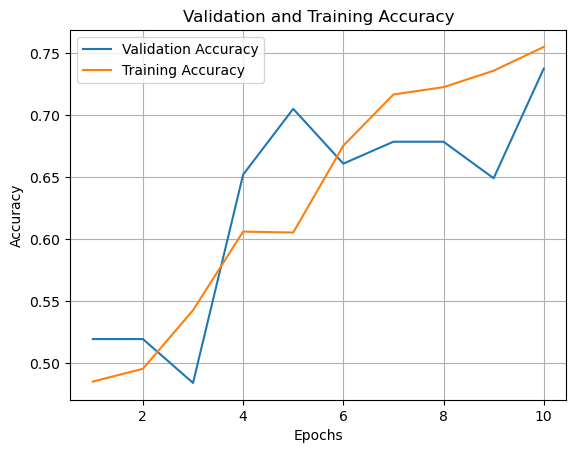

In [9]:
import matplotlib.pyplot as plt

# Supponiamo che tu abbia già addestrato il modello utilizzando model.fit()

# Ottieni i risultati dell'addestramento dallo storico del modello

# Recupera i valori di val_accuracy e accuracy per ogni epoca
val_accuracy = history.history['val_accuracy']
accuracy = history.history['accuracy']
epochs = range(1, len(val_accuracy) + 1)

# Plotta i risultati
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()


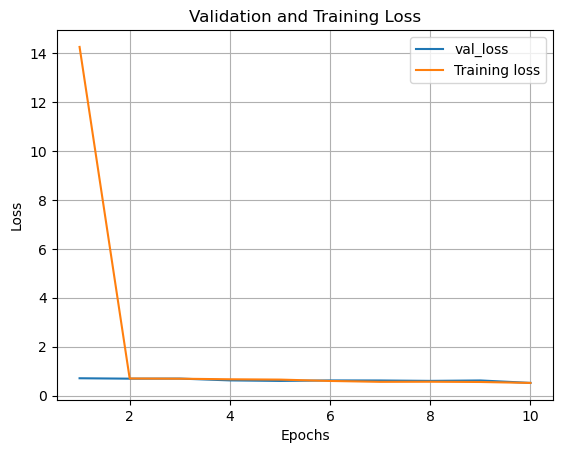

In [10]:
import matplotlib.pyplot as plt

# Supponiamo che tu abbia già addestrato il modello utilizzando model.fit()

# Ottieni i risultati dell'addestramento dallo storico del modello

# Recupera i valori di val_accuracy e accuracy per ogni epoca
val_accuracy = history.history['val_loss']
accuracy = history.history['loss']
epochs = range(1, len(val_accuracy) + 1)

# Plotta i risultati
plt.plot(epochs, val_accuracy, label='val_loss')
plt.plot(epochs, accuracy, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation and Training Loss')
plt.legend()
plt.grid(True)
plt.show()


# VGG16 with 5 brand


In [36]:
# Convert labels to one-hot encoded vectors
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

# Load the VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

"""# Add attention mechanism
attention = Dense(1, activation='tanh')(base_model.output)
attention = GlobalAveragePooling2D()(attention)
attention = Multiply()([base_model.output, attention])"""

# Add the top classification layer by applying a dense layer with a tanh activation function, followed by global average pooling and element-wise multiplication.
output = GlobalAveragePooling2D()(attention)
# Use global average pooling and a dense layer with softmax activation for multi-class classification.
output = Dense(num_classes, activation='softmax')(output)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_4_brand_50_epoch= model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 50, batch_size=32)

# Save the trained model
model.save('./history_4_brand_50_epoch.h5') 


Epoch 1/50


2023-07-24 17:53:38.282026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 1.4576 - accuracy: 0.3493

2023-07-24 17:56:01.669322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 152s 2s/step - loss: 1.4576 - accuracy: 0.3493 - val_loss: 1.1064 - val_accuracy: 0.3924
Epoch 2/50
63/63 [==============================] - 167s 3s/step - loss: 1.0945 - accuracy: 0.3563 - val_loss: 1.0919 - val_accuracy: 0.4064
Epoch 3/50
63/63 [==============================] - 169s 3s/step - loss: 1.0878 - accuracy: 0.3642 - val_loss: 1.0596 - val_accuracy: 0.4303
Epoch 4/50
63/63 [==============================] - 188s 3s/step - loss: 1.0376 - accuracy: 0.4310 - val_loss: 1.0509 - val_accuracy: 0.4004
Epoch 5/50
63/63 [==============================] - 203s 3s/step - loss: 1.0205 - accuracy: 0.4614 - val_loss: 1.0141 - val_accuracy: 0.4363
Epoch 6/50
63/63 [==============================] - 205s 3s/step - loss: 0.9792 - accuracy: 0.5007 - val_loss: 0.9535 - val_accuracy: 0.5199
Epoch 7/50
63/63 [==============================] - 220s 3s/step - loss: 0.9569 - accuracy: 0.5097 - val_loss: 0.9132 - val_accuracy: 0.5637
Epoch 8/50
63/63 [======

/Users/elenaabcc/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
import json 
json.dump(history_4_brand_50_epoch.history, open('history_100.json', 'w'))

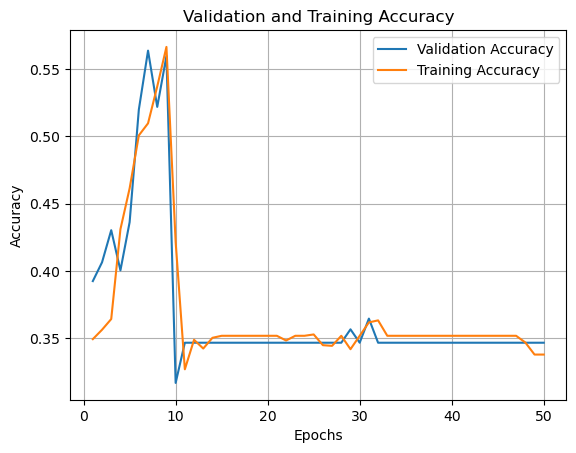

In [38]:
import matplotlib.pyplot as plt

# Supponiamo che tu abbia già addestrato il modello utilizzando model.fit()

# Ottieni i risultati dell'addestramento dallo storico del modello

# Recupera i valori di val_accuracy e accuracy per ogni epoca
val_accuracy = history_4_brand_50_epoch.history['val_accuracy']
accuracy = history_4_brand_50_epoch.history['accuracy']
epochs = range(1, len(val_accuracy) + 1)

# Plotta i risultati
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()


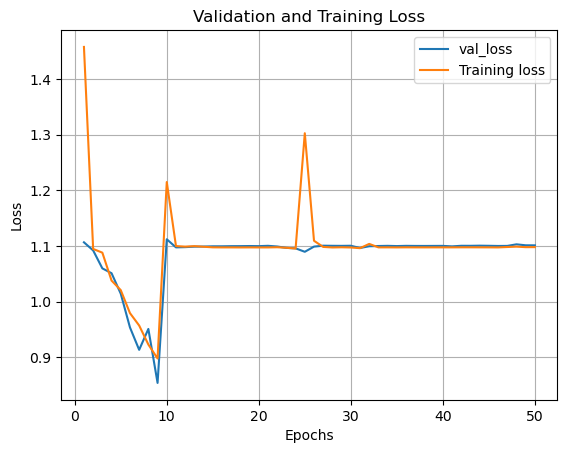

In [39]:
import matplotlib.pyplot as plt

# Supponiamo che tu abbia già addestrato il modello utilizzando model.fit()

# Ottieni i risultati dell'addestramento dallo storico del modello

# Recupera i valori di val_accuracy e accuracy per ogni epoca
val_accuracy = history_4_brand_50_epoch.history['val_loss']
accuracy = history_4_brand_50_epoch.history['loss']
epochs = range(1, len(val_accuracy) + 1)

# Plotta i risultati
plt.plot(epochs, val_accuracy, label='val_loss')
plt.plot(epochs, accuracy, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation and Training Loss')
plt.legend()
plt.grid(True)
plt.show()


# Simple VGG16

In [5]:

# Create the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

# Add the top classification layers
output = GlobalAveragePooling2D()(base_model.output)
output = Dense(1024, activation='relu')(output)
output = Dense(num_classes, activation='softmax')(output)

# Create the custom VGG16 model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

# Save the trained model
model.save('./custom_vgg16_model.h5')

2023-08-03 22:23:12.381324: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-08-03 22:23:12.381673: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-08-03 22:23:12.381882: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-08-03 22:23:12.382566: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-03 22:23:12.383219: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/5


2023-08-03 22:23:15.581578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/63 [===============>..............] - ETA: 1:07 - loss: 4.7396 - accuracy: 0.3580

KeyboardInterrupt: 

# Attention heatmap

1/1 [==============================] - 0s 64ms/step


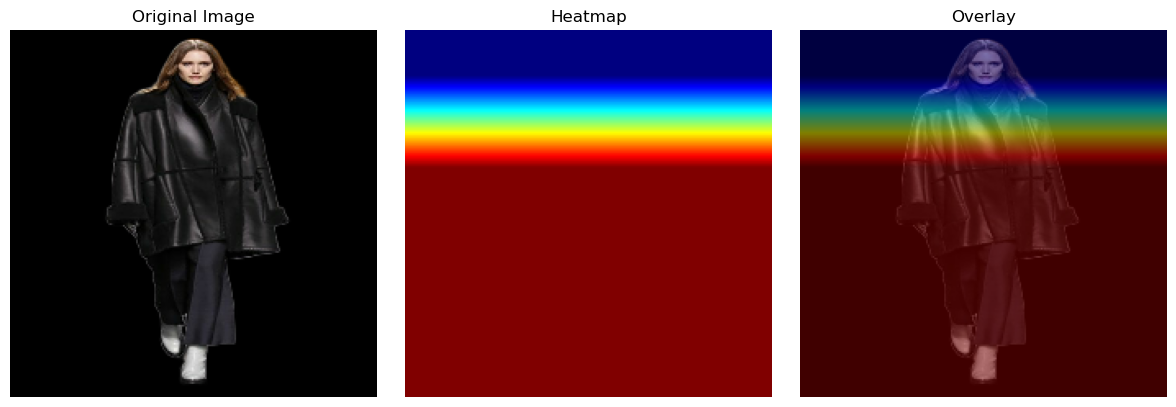

In [85]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the preprocess_image function to load, resize, and normalize the pixel values of the images.
def preprocess_image(image_path):
    image_path = './imgs/images/images/' + image_path  # Add the path prefix
    image = load_img(image_path, target_size=(img_height, img_width))
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image

# Choose an image for generating the heatmap
image_path = 'hermes-ready-to-wear-fall-winter-2016-paris-18627/Hermes-Ready-To-Wear-Fall-Winter-2016-Fashion-Show-Runway-Paris-Fashion-Week-0017-466x700-no-bkgnd.jpg'
image = preprocess_image(image_path)

# Reshape the image to match the model's input shape
image = np.expand_dims(image, axis=0)

# Get the feature maps from the model
conv_output = model.predict(image)

# Get the weights of the last dense layer (output layer) in the model
weights = model.layers[-1].get_weights()[0]

# Calculate the gradients of the predicted class with respect to the feature maps
grads = np.mean(conv_output, axis=(0, 1))

# Multiply the gradients with the pooled gradients to obtain the importance of each feature map channel
heatmap = np.mean(conv_output[0], axis=-1) * grads

# Normalize the heatmap between 0 and 1
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Resize the heatmap to match the original image size
heatmap = cv2.resize(heatmap, (image.shape[2], image.shape[1]))

# Apply a colormap to the heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

# Overlay the heatmap on the original image
overlay = cv2.addWeighted(np.uint8(255 * image[0]), 0.5, heatmap, 0.5, 0)

# Plot the original image, heatmap, and overlay
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax[0].imshow(image[0])
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(heatmap)
ax[1].set_title('Heatmap')
ax[1].axis('off')
ax[2].imshow(overlay)
ax[2].set_title('Overlay')
ax[2].axis('off')
plt.tight_layout()
plt.show()


In [ ]:

# Define image and label dimensions (img_height and img_width) to resize the images during preprocessing.
img_height, img_width = 224, 224
